<a href="https://colab.research.google.com/github/mariomicolta/PySpark-demo/blob/main/PySpark_Craiglist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***John Mario Micolta Garzón*** </br>
*Ingeniero de Sistemas* </br>
*Científico de Datos* </br>
*3173301901* </br>
*mariomicolta@gmail.com*

# CONFIGURACIÓN DEL ENTORNO PARA PODER EJECUTAR SPARK EN GOOGLE COLAB
A continuación, se realizarán una serie de pasos con el fin de configurar el ambiente de desarrollo Google Colab para poder utilizar Apache Spark en su última versión.

**Saltarse hasta el título: CASO DE NEGOCIO 1**

## Instalación Java

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

## Obtener automáticamente la última versión de Spark

In [2]:
from bs4 import BeautifulSoup
import requests

#Obtener las versiones de spark la pagina web
url = 'https://downloads.apache.org/spark/' 
r = requests.get(url)
html_doc = r.text
soup = BeautifulSoup(html_doc)

# leer la pagina web y obtener las versiones de spark disponibles
link_files = []
for link in soup.find_all('a'):
  link_files.append(link.get('href'))
spark_link = [x for x in link_files if 'spark' in x]  

ver_spark = spark_link[2][:-1] # obtener la version y eliminar el caracter '/' del final
print(ver_spark)

## Descargar e instalar PySpark.

Dado que el core de Spark está construido en Scala, es necesario utilizar su interface para Python. Por lo tanto, se descarga e instala **PySpark**.

In [6]:
import os 
os.system(f"wget -q https://www-us.apache.org/dist/spark/{ver_spark}/{ver_spark}-bin-hadoop2.7.tgz")
os.system(f"tar xf {ver_spark}-bin-hadoop2.7.tgz")

!pip install -q pyspark

     |████████████████████████████████| 212.3MB 64kB/s 
     |████████████████████████████████| 204kB 17.7MB/s 


## Configuración del entorno

In [7]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{ver_spark}-bin-hadoop2.7"

## Configuración de Kaggle
Dado que para realizar este ejercicio se utilizó el notebook gratuito que ofrece Google Colab, se consideró pertinente realizar la descarga de los datos desde Kaggle directamente al notebook. Para más información consultar el siguiente link: [Easiest way to download kaggle data in Google Colab - Kaggle Forum](https://www.kaggle.com/general/74235) o [How to use the Kaggle API from Colab](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).

Por lo tanto, se procedió a configurar Kaggle en este notebook.

In [9]:
!pip install -q kaggle

In [10]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mariomicolta","key":"61ffb4cad712029ddbdee1ab1e305d6a"}'}

In [11]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [15]:
!kaggle datasets download -d austinreese/craigslist-carstrucks-data

 95% 250M/262M [00:04<00:00, 50.4MB/s]
100% 262M/262M [00:04<00:00, 57.4MB/s]


In [16]:
!mkdir data
!unzip craigslist-carstrucks-data.zip -d data

Archive:  craigslist-carstrucks-data.zip
  inflating: data/vehicles.csv       


# CASO DE NEGOCIO 1

**Sobre los datos:** Craigslist es la colección de vehículos usados ​​a la venta más grande del mundo. Los datos fueron capturados de sitio web de anuncios clasifiacos **Craiglist** a través de Web Scraping. Estos datos se recogen cada pocos meses, contienen la mayor parte de la información relevante que Craigslist proporciona sobre las ventas de automóviles, incluidas las siguientes columnas: *id, url, region, region_url, price, year, manufacturer, model, condition, cylinders, fuel, odometer, title_status, transmission, VIN, drive, size, type, paint_color, image_url, description, county, state, lat, long, posting_date*.

Para más informacion, consultar los siguientes links:


[Used Cars Dataset](https://www.kaggle.com/austinreese/craigslist-carstrucks-data/)

[Used Vehicle Search](https://github.com/AustinReese/UsedVehicleSearch)

[Craiglist - Wikipedia](https://es.wikipedia.org/wiki/Craigslist)

[Craiglist - Web Oficial](https://craigslist.org/)

## Importación de las librerias 
Se realizó el cargue de librerías y funciones requeridas para cumplir los objetivos de este ejercicio.

In [154]:
from datetime import datetime, date
from pyspark.sql.types import DoubleType, DateType, StringType
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
import matplotlib.pyplot as plt

Creamos la sesión de Spark para poder acceder a todas las funcionalidades del Stack Apache Spark (SQL, Streaming, MLlib, GraphX). 

In [102]:
spark = SparkSession.builder.appName("Test_spark").master("local[*]").getOrCreate()

## Carga de datos

Se realizó la carga de los datos previamente descargados en formato csv. Se le indica a Spark que la primera columna es la cabecera del dataframe.

In [109]:
df = spark.read.load('./data/vehicles.csv', format = 'csv', header = True)

Con la intención de conocer una aproximación de los datos disponibles, se imprimen los primeros 20 registros y la estructura de dataframe. 

In [104]:
df.show()
df.printSchema()

+----------+--------------------+--------------------+--------------------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+
|        id|                 url|              region|          region_url|price|year|manufacturer|model|condition|cylinders|fuel|odometer|title_status|transmission| VIN|drive|size|type|paint_color|image_url|description|county|state| lat|long|posting_date|
+----------+--------------------+--------------------+--------------------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+
|7222695916|https://prescott....|            prescott|https://prescott....| 6000|null|        null| null|     null|     null|null|    null|        null|        null|null| null|null|null|       null|     null|       null|  null|  

## Tipos de datos

Se observó que Spark no infirió los tipos de datos; es decir, cargó todas las columnas con el tipo de dato **string**, aún cuando hay variables numéricas: *price y odometer*. 

Se procedió a crear 3 arrays con los nombres de las variables numéricas, categóricas y de elementos temporales por separado. Esto con el objetivo de facilitar el cambio de tipo de datos por batch y no individualmente. Además, se creó una función para encapsular toda la funcionalidad de cambiar el tipo de variable (reutilización de código).

In [105]:
cols_numericas = ['price', 'odometer']
cols_categoricas = ['id', 'url', 'region', 'region_url', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission',
 'VIN', 'drive', 'size', 'type', 'paint_color', 'image_url', 'description', 'county', 'state', 'lat', 'long', 'posting_date']
cols_dates = ['year']

def setDatatype(df, arr_variables, datatype):
  for col in arr_variables:
    df = df.withColumn(col, df[col].cast(datatype))
    return df

df = setDatatype(df, cols_numericas, DoubleType())
df = setDatatype(df, cols_categoricas, StringType())
df = setDatatype(df, cols_dates, DateType())

Se validó que se hayan aplicado los cambios.

In [106]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_url: string (nullable = true)
 |-- price: double (nullable = true)
 |-- year: date (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: string (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- VIN: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- description: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- posting_date: string (null

Para poder utilizar las capacidades SQL que provee Spark, se registró el dataframe como una tabla.

In [107]:
df.createOrReplaceTempView("all_data")

# **PUNTO 1**: En el campo **year** deja solo el año, quitanto el "." y el "0".

Se realizó una inspección visual de los datos y se determinó que estos no son consistentes en su estructura. Por ejemplo: se encontró que existen fechas en formato AÑO (*2021*) y otras en formato timestamp (*2021-04-25T14:03:05-0700*).

In [ ]:
#df.filter(df.year != 'null').distinct().select(['id', 'year']).show(200, truncate = False)

Se procedió a formatear las fechas en formato timestamp a formato año.

In [241]:
from pyspark.sql.functions import year
#df.select(year(df.year)).show(10 , False)
spark.sql("SELECT EXTRACT(year from `year`) AS year FROM all_data WHERE year IS NOT NULL").show(10, False)
#spark.sql('SELECT id, date_format(year, "y") AS year FROM all_data WHERE year IS NOT NULL').show(10, False)
#df.withColumn("year", year(df['year'].cast(DateType()))).select(['year']).show(10, False)

+----+
|year|
+----+
|2014|
|2010|
|2020|
|2017|
|2013|
|2012|
|2016|
|2019|
|2016|
|2011|
+----+
only showing top 10 rows



# **PUNTO 2**: Informa cuántas regiones diferentes hay y cuántos registros hay por cada región.

El resultado de las consulta se almacena en una vista.  

In [152]:
regiones = spark.sql("SELECT region, COUNT(region) AS cant_rows FROM all_data GROUP BY region ORDER BY cant_rows DESC")
regiones.createOrReplaceTempView("regiones")

cantidad_regiones = spark.sql("SELECT COUNT(region) AS cant_regiones FROM regiones")
regiones.createOrReplaceTempView("cantidad_regiones")
cantidad_regiones.show()

+-------------+
|cant_regiones|
+-------------+
|          833|
+-------------+



Se encontró que existen **833** regiones.

La siguiente tabla, muestra las 10 regiones en las que más autos se alquilan según el periodo de tiempo estudiado.

In [155]:
regiones.show(10, truncate = False)

+------------------------+---------+
|region                  |cant_rows|
+------------------------+---------+
|columbus                |3608     |
|jacksonville            |3562     |
|spokane / coeur d'alene |2988     |
|eugene                  |2985     |
|fresno / madera         |2983     |
|orlando                 |2983     |
|bend                    |2982     |
|omaha / council bluffs  |2982     |
|new hampshire           |2981     |
|kennewick-pasco-richland|2981     |
+------------------------+---------+
only showing top 10 rows



Convertimos el dataframe de Spark a pandas para facilitar la manipulación a la hora de graficar.

In [163]:
regiones_pd = regiones.toPandas()
regiones_pd = regiones_pd.astype({"region": str, "cant_rows": int}) 

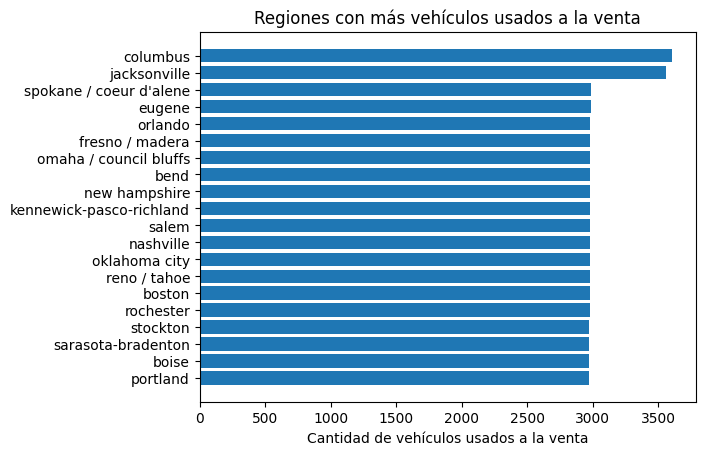

In [251]:
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(regiones_pd.region[:20], regiones_pd.cant_rows[:20], align='center')
ax.set_yticks(regiones_pd.region[:20])
ax.set_yticklabels(regiones_pd.region[:20])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Cantidad de vehículos usados a la venta')
ax.set_title('Regiones con más vehículos usados a la venta')

plt.show()

# **PUNTO 3**: Genera un archivo con los registros que están completos descartando aquellos que tienen algunos de sus campos nulos.

El resultado de la consulta se guardó en archivos .csv y .parquet. 

In [184]:
clean_data = df.dropna(how = 'any')
clean_data.write.save("clean_data.parquet", format="parquet")
clean_data.write.save("clean_data.csv", format="csv")
clean_data.count()

4305

Se encontró que existen **4305** registros con todos sus campos diligenciados.

In [183]:
clean_data.show()

+----------+--------------------+--------------------+--------------------+-----+----+------------+--------------------+---------+------------+------+--------+------------+------------+-----------------+-----+---------+-----------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        id|                 url|              region|          region_url|price|year|manufacturer|               model|condition|   cylinders|  fuel|odometer|title_status|transmission|              VIN|drive|     size|       type|paint_color|           image_url|         description|              county|               state|                 lat|                long|        posting_date|
+----------+--------------------+--------------------+--------------------+-----+----+------------+--------------------+---------+------------+------+--------+------------+------------+-----------------+-----+---------

# **PUNTO 4**: Trae los registros donde el **price** sea >= 15000 y la condición del auto sea **good** o **excellent**.

Para validar los nombres exactos de los tipos de condición del auto, se listan todos las disponibles.

In [190]:
clean_data.select(['condition']).distinct().show()

+---------+
|condition|
+---------+
|      new|
|     2006|
|    E350 |
|excellent|
|   35 mpg|
|  salvage|
| like new|
|    f250 |
|     good|
|     fair|
+---------+



Esta consulta se realizó utilizando la API de spark y no las sentencias SQL.

In [187]:
autos_buenos_mayor_15000 = df.filter((df.price >= 15000) & (df.condition == 'good') | (df.condition == 'excellent'))
autos_buenos_mayor_15000.select(['id', 'price', 'model', 'condition']).show(10, truncate = False)

+----------+-----+---------------------------+---------+
|id        |price|model                      |condition|
+----------+-----+---------------------------+---------+
|7316814884|33590|sierra 1500 crew cab slt   |good     |
|7316814758|22590|silverado 1500             |good     |
|7316814989|39590|silverado 1500 crew        |good     |
|7316743432|30990|tundra double cab sr       |good     |
|7316356412|15000|f-150 xlt                  |excellent|
|7316343444|27990|sierra 2500 hd extended cab|good     |
|7316304717|34590|silverado 1500 double      |good     |
|7316285779|35000|tacoma                     |excellent|
|7316257769|29990|colorado extended cab      |good     |
|7316133914|38590|corvette grand sport       |good     |
+----------+-----+---------------------------+---------+
only showing top 10 rows



# **PUNTO 5**: Realiza el conteo de los autos azules manufacturados por chevrolet.

In [195]:
spark.sql('SELECT COUNT(id) as Cantidad_autos_azules FROM all_data WHERE paint_color = "blue" AND manufacturer = "chevrolet"').show()

+---------------------+
|Cantidad_autos_azules|
+---------------------+
|                 3660|
+---------------------+



Se tiene que, 3660 vehículos usados que están a la venta son de color azul y fabricados por Chevrolet.

# **PUNTO 6**: Haz que los autos negros se conviertan en azules y que los azules se conviertan en rojos. Muestra los resultados en una gráfica.

Se graficó la distribución de los vehículos según los colores: *negro, azul y rojo* antes de la transformación de los datos.

In [298]:
vehiculos_color_prev = spark.sql('SELECT paint_color, COUNT(id) as cantidad FROM all_data WHERE paint_color IN ("black", "blue", "red") GROUP BY paint_color ORDER BY cantidad DESC')
vehiculos_color_prev.show()

+-----------+--------+
|paint_color|cantidad|
+-----------+--------+
|      black|   62861|
|       blue|   31223|
|        red|   30473|
+-----------+--------+



Convertimos a pandas para poder manipular

In [268]:
vehiculos_color_prev_pd = vehiculos_color_prev.toPandas()
vehiculos_color_prev_pd = vehiculos_color_prev_pd.astype({"paint_color": str, "cantidad": int}) 

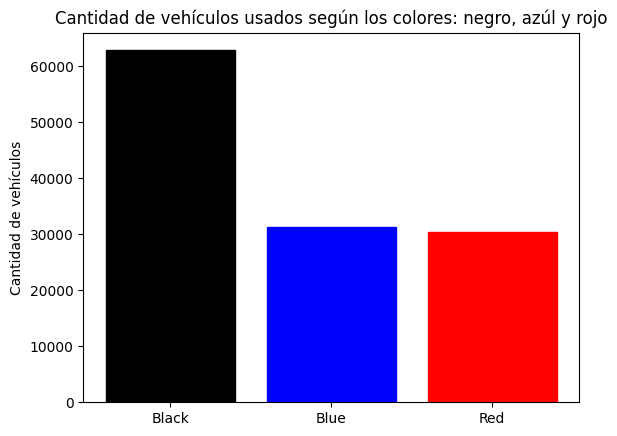

In [305]:
def plotBarsCarsColors(df):
  df = df.toPandas()
  df = df.astype({"paint_color": str, "cantidad": int}) 

  plt.rcdefaults()
  fig, ax = plt.subplots()

  bar_plt = ax.bar(df.paint_color, df.cantidad, align='center')
  bar_plt[0].set_color('black')
  bar_plt[1].set_color('blue')
  bar_plt[2].set_color('red')

  ax.set_xticks(df.paint_color)
  ax.set_xticklabels(df.paint_color.str.capitalize())
  ax.set_ylabel('Cantidad de vehículos')
  ax.set_title('Cantidad de vehículos usados según los colores: negro, azúl y rojo')

  plt.show()


plotBarsCarsColors(vehiculos_color_prev)

Filtramos por colores y, luego realizamos la respectiva condición.

In [318]:
vehiculos_color_post = df.filter((df.paint_color == 'black') | (df.paint_color == 'blue') | (df.paint_color == 'red')).withColumn("paint_color", when(df.paint_color == 'black', 'blue').when(df.paint_color == 'blue', 'red').otherwise(df.paint_color)).select('paint_color')
vehiculos_color_post = vehiculos_color_post.groupBy('paint_color').count().withColumnRenamed("count", "cantidad")

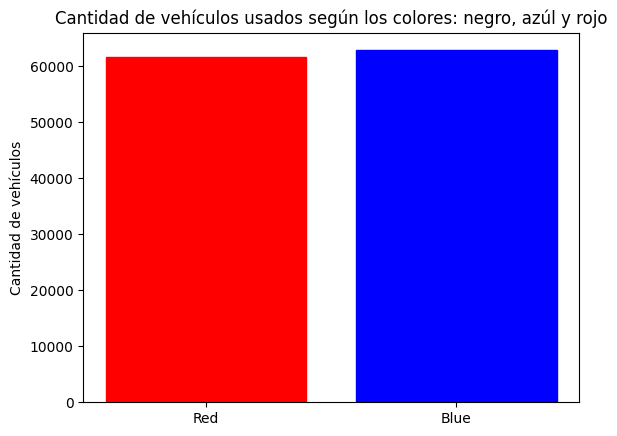

In [320]:
def plotBarsCarsColors2(df):
  df = df.toPandas()
  df = df.astype({"paint_color": str, "cantidad": int}) 

  plt.rcdefaults()
  fig, ax = plt.subplots()

  bar_plt = ax.bar(df.paint_color, df.cantidad, align='center')
  bar_plt[0].set_color('red')
  bar_plt[1].set_color('blue')

  ax.set_xticks(df.paint_color)
  ax.set_xticklabels(df.paint_color.str.capitalize())
  ax.set_ylabel('Cantidad de vehículos')
  ax.set_title('Cantidad de vehículos usados según los colores: negro, azúl y rojo')

  plt.show()


plotBarsCarsColors2(vehiculos_color_post)

-----------------------------

***John Mario Micolta Garzón*** </br>
*Ingeniero de Sistemas* </br>
*Científico de Datos* </br>
*3173301901* </br>
*mariomicolta@gmail.com*

